In [1]:
%matplotlib notebook
import numpy as np
import sympy as sym
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sci
from scipy.signal import find_peaks, peak_widths
from scipy.special import wofz
from scipy.optimize import curve_fit
from scipy.constants import e
from scipy.constants import c
from scipy.constants import h
from matplotlib import rc
from IPython.display import display, Math, Markdown
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)
path = "C:/Users/Thomas/Laboratorio_Intermedio/X-Rays/Data/"

In [2]:
def Lorentzian(x, h, x0, W):
    return h*(W**2)/(((x-x0)**2) + (W**2))

def Linear(X, a, b):
    return a*X + b

def Gauss(x, y0, a, x0, sigma):
    return y0 + a*np.exp(-((x - x0)**2)/(2*(sigma**2)))

def Voigt(x, amplitude, center, sigma, gamma):
    z = ((x - center) + 1j*gamma)/(sigma*np.sqrt(2))
    v = amplitude*wofz(z).real/(sigma*np.sqrt(2*np.pi))
    return v

def ChangeType(array):
    array_ = array.copy()
    for i in range(0, len(array)):
        array_[i] = float(array[i].replace(",", "."))
    return array_

def SetWave(array, d, phase):
    array_ = array.copy()
    for i in range(0, len(array)):
        array_[i] = 2*d*np.sin(np.radians(array[i] - phase))
    return array_

def SetLog(array):
    array_ = array.copy()
    for i in range(0, len(array)):
        array_[i] = np.log(array[i])
    return array_

def Error(valor_principal, incertidumbre):
    # Determinar cuántas cifras significativas tiene la incertidumbre
    if incertidumbre == 0:
        return valor_principal, incertidumbre  # Evita la división por cero
    
    cifras_significativas = -int(math.floor(math.log10(incertidumbre)))
    
    # Redondear el valor principal y la incertidumbre a esas cifras significativas
    valor_redondeado = round(valor_principal, cifras_significativas)
    incertidumbre_redondeada = round(incertidumbre, cifras_significativas)
    
    return valor_redondeado, incertidumbre_redondeada

def Computation_Error(expression, symbols, parameters):
    error_2 = 0.
    ward = int((len(symbols)/2))
    func_value = sym.lambdify(symbols[0:ward], expression)
    value = func_value(*parameters[0:ward])

    for i in range(0, len(symbols[0:ward])):
        unc_ward = ward + i
        error_2 += sym.diff(expression, symbols[i])**2 * (symbols[unc_ward])**2

    func_error_2 = sym.lambdify(symbols, error_2)
    value_error_2 = func_error_2(*parameters)
    
    error = np.sqrt(value_error_2)
    
    value, error = Error(value, error)
    
    return value, error

> ## Bitácora - Experimento de Rayos X (Radiación Röntgen)

**Hecho por:** Simón Felipe Jimenez Botero & Thomas Andrade Hernández.

---

En el presente documento se encuentran desglozados los resultados de las mediciones asociadas al montaje experimental de Rayos X. A lo largo de este código se podrán observar los resultados de cada medición, gráficas e información relacionada a cada una de las regresiones que se realicen, sumado a una breve explicación previa acerca de aquello que estamos haciendo, cómo lo estamos haciendo y alguna que otra cosa a tener presente para su replicación.

---

> **Montaje Experimental:**

Las mediciones que fueron realizadas a lo largo de las horas de laboratorio son derivadas del siguiente montaje experimental:

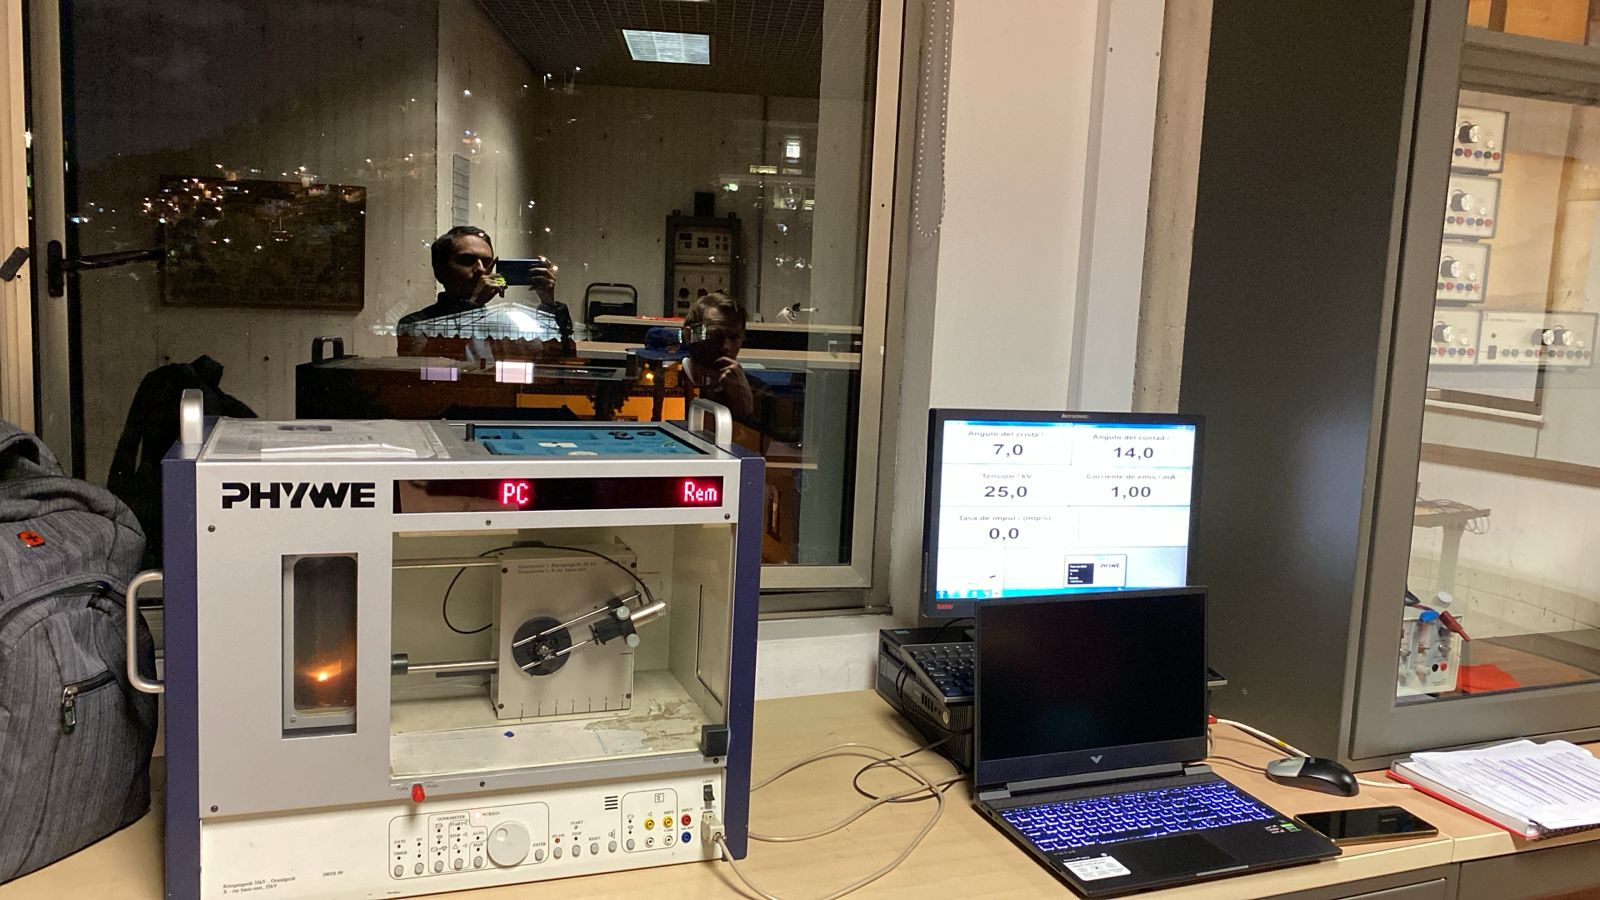

En la parte izquierda de la imagen se logra apreciar la herramienta encargada de emitir y medir los Rayos X, a la derecha un computador encargado de manipular el software que configura y automatiza las mediciones de la máquina de PHYWE.

> **Primera Sesión: Octubre 10 - 2024.**

**Calibración:** Para esta primera sesión se debe de considerar la siguiente configuración asociada a la intensidad máxima medida y los ángulos asociados a cada uno de los componentes:

**Intensidad Máxima:** $6900$ $I/s$

**Ángulo del Cristal:** $20.5^{\circ}$

**Ángulo del Detector:** $40.9^{\circ}$

En esta sesión se logró completar la Actividad #1 y empezar a realizar la Actividad #2. De esta última completamos todas las mediciones asociadas al Aluminio y tomamos una medición para el Zinc.

> **Actividad #1: Rayos X característicos del Cobre.**

En este apartado tomamos el espectro del cobre en una vecindad de ángulos concreta. A continuación se muestra la imagen del espectro obtenida.

**Nota:** La tendencia decreciente inicial se puede llegar a explicar por la forma en como inciden los Rayos X en la región. Posiblemente los Rayos X pasan directamente al detector porque el cristal no refleja de forma adecuada. Los dos pares de picos representan las mismas líneas espectrales de $K_{\alpha}$ y $K_{\beta}$, sólo que el primer par se encuentra descrito por el primer orden de difracción ($n = 1$), mientras que el segundo par al segundo orden $(n = 2)$.

In [3]:
Copper = "Cu Spectre.txt"
CopperPattern = pd.read_csv(path + Copper, sep = "	")

CuAngles = CopperPattern["Angle"].to_numpy()
CuInten = CopperPattern["Intensity"].to_numpy()

CuAngles = ChangeType(CuAngles)
CuInten = ChangeType(CuInten)

<IPython.core.display.Javascript object>


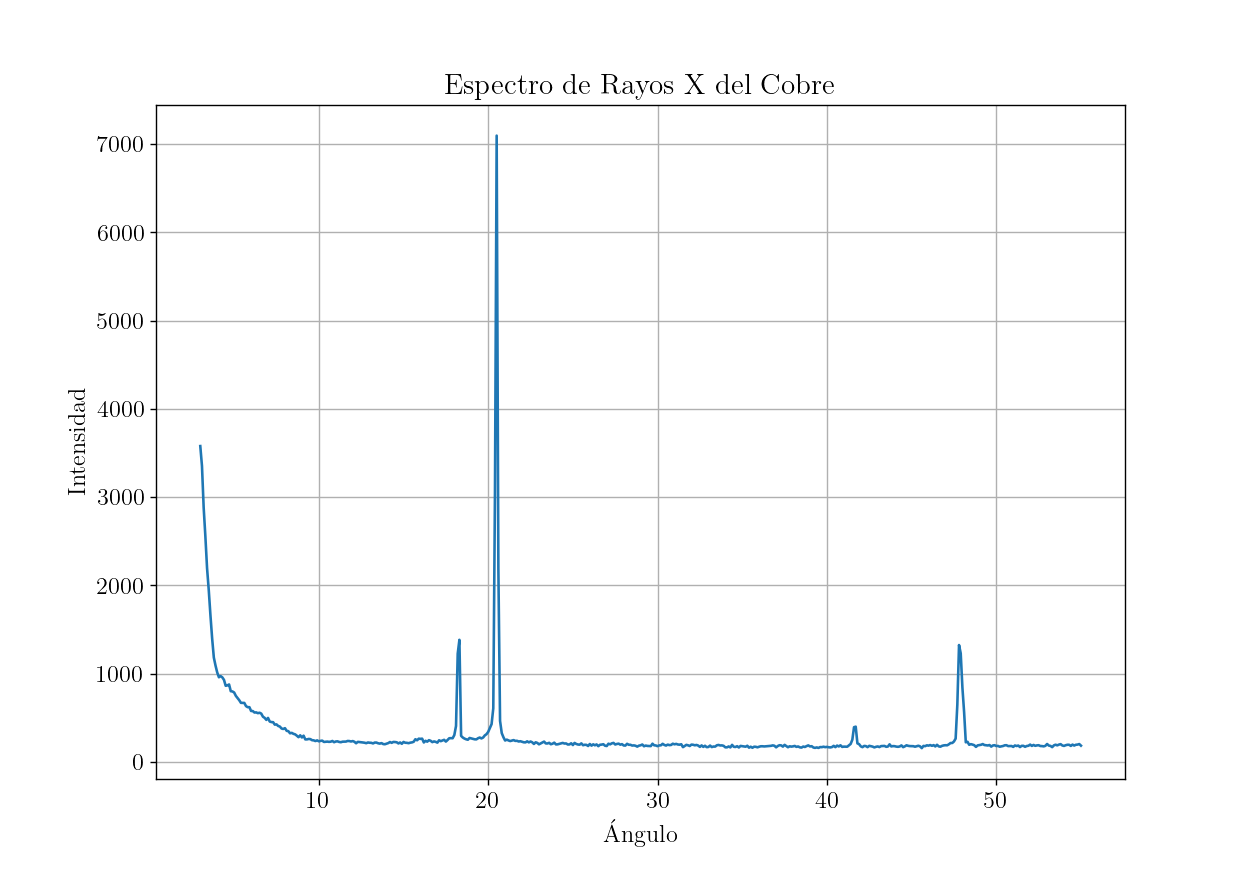

In [4]:
plt.figure(figsize = (10, 7))
plt.plot(CuAngles, CuInten)
plt.ylabel("Intensidad")
plt.title("Espectro de Rayos X del Cobre")
plt.xlabel("Ángulo")
plt.grid(True)

Esta gráfica es meramente ilustrativa, similar a la que el programa de medición generó. Para el paso a longitud de onda se utiliza la ley de Bragg:

$$2d\sin\theta = n\lambda$$

Se delimitarán las regiones en donde salen las líneas espectrales y se hará un ajuste angular en función de qué tan desfasadas se encuentran las longitudes de onda.

In [5]:
d = 2.014 # metros
phase = -2

x1 = []
x2 = []
y1 = []
y2 = []

for i in range(0, len(CuAngles)):
    if 17.0 <= CuAngles[i] <= 22.0:
        x1.append(2*d*np.sin(np.radians(CuAngles[i] - phase)))
        y1.append(CuInten[i])
    if 40 <= CuAngles[i] <= 50:
        x2.append(2*d*np.sin(np.radians(CuAngles[i] - phase))/2)
        y2.append(CuInten[i])

<IPython.core.display.Javascript object>


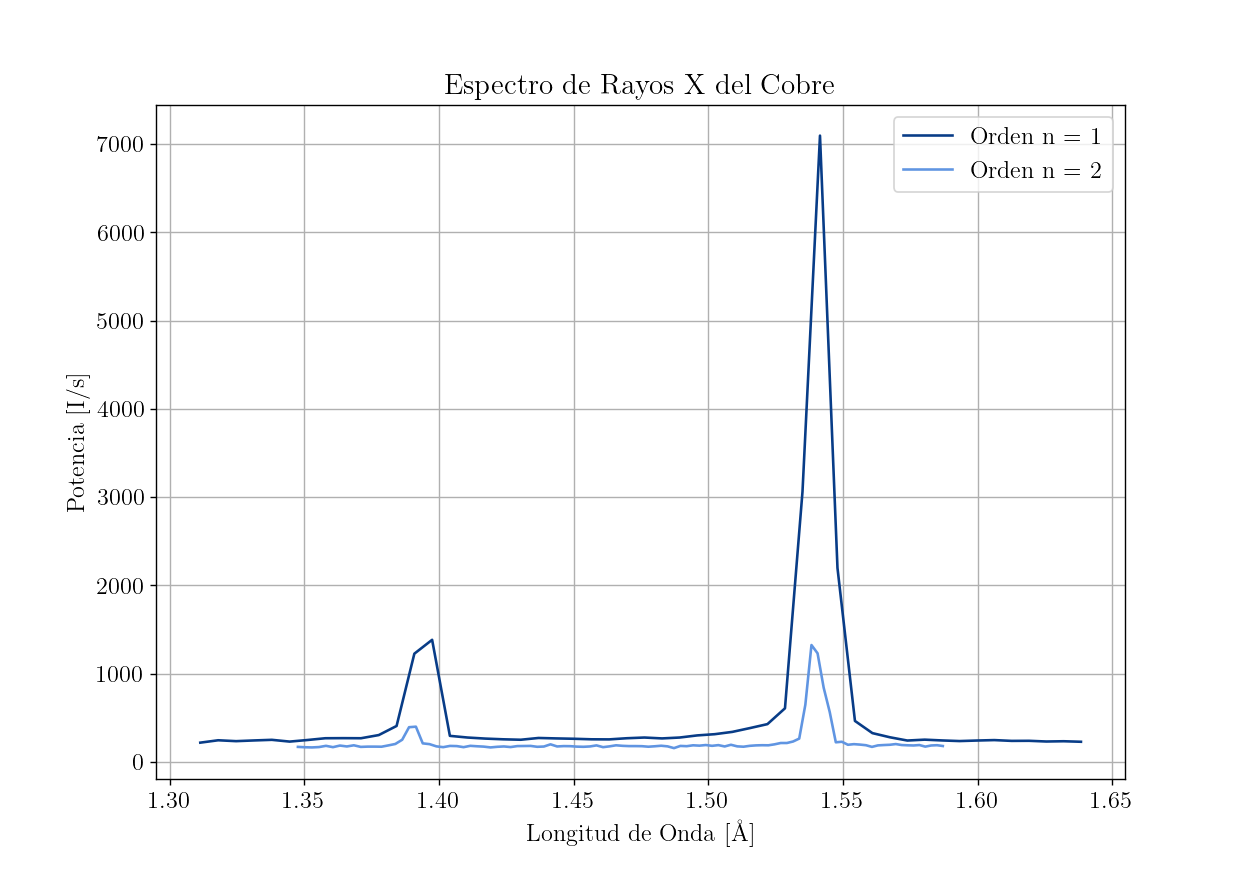

In [6]:
plt.figure(figsize = (10, 7))
plt.plot(x1, y1, color = "#083c87", label = "Orden n = 1")
plt.plot(x2, y2, color = "#6095e2", label = "Orden n = 2")
plt.xlabel("Longitud de Onda [Å]")
plt.ylabel("Potencia [I/s]")
plt.title("Espectro de Rayos X del Cobre")
plt.legend()
plt.grid()
plt.show()

Ya habiendo determinado el desfase de la máquina y encontrado la correspondencia en términos de la longitud de onda, es necesario hallar las longitudes de onda y energías de cada pico. Para ello se presenta el siguiente código que implementa un ajuste de tipo Lorentziano y otro mediante un perfil de Voight:

In [7]:
# Conjunto de datos para la linea espectral Kb para n = 1.
x1L1 = []
y1L1 = []

# Conjunto de datos para la linea espectral Ka para n = 1.
x1L2 = []
y1L2 = []

# Conjunto de datos para la linea espectral Kb para n = 2.
x2L1 = []
y2L1 = []

# Conjunto de datos para la linea espectral Ka para n = 2.
x2L2 = []
y2L2 = []

for i in range(0, len(x1)):
    if 1.38 <= x1[i] <= 1.46:
        x1L1.append(x1[i])
        y1L1.append(y1[i])
    if 1.46 <= x1[i] <= 1.60:
        x1L2.append(x1[i])
        y1L2.append(y1[i]) 

for i in range(0, len(x2)):
    if 1.375 <= x2[i] <= 1.41:
        x2L1.append(x2[i])
        y2L1.append(y2[i])
    if 1.50 <= x2[i] <= 1.56:
        x2L2.append(x2[i])
        y2L2.append(y2[i]) 

In [8]:
# Lorentzianas para n = 1:

ILorenICu_var, ILorenICu_unc = curve_fit(Lorentzian, x1L1, y1L1)
ILorenICu_unc = np.sqrt(np.diag(ILorenICu_unc))

x1L1_ = np.linspace(min(x1), max(x1L1), 1000)

ILorenIICu_var, ILorenIICu_unc = curve_fit(Lorentzian, x1L2, y1L2)
ILorenIICu_unc = np.sqrt(np.diag(ILorenIICu_unc))

x1L2_ = np.linspace(min(x1L2), max(x1), 1000)

y1L1_Res = y1L1 -  Lorentzian(x1L1, *ILorenICu_var)
y1L2_Res = y1L2 -  Lorentzian(x1L2, *ILorenIICu_var)

# Lorentzianas para n = 2:

IILorenICu_var, IILorenICu_unc = curve_fit(Lorentzian, x2L1, y2L1)
IILorenICu_unc = np.sqrt(np.diag(IILorenICu_unc))

x2L1_ = np.linspace(min(x2), min(x2L2) - 0.02, 1000)

IILorenIICu_var, IILorenIICu_unc = curve_fit(Lorentzian, x2L2, y2L2)
IILorenIICu_unc = np.sqrt(np.diag(IILorenIICu_unc))

x2L2_ = np.linspace(min(x2L2)-0.02, max(x2), 1000)

ward = int(round(len(y2)/2,0))

y2L1_Res = y2[0:ward] -  Lorentzian(x2[0:ward], *IILorenICu_var)
y2L2_Res = y2[ward:] -  Lorentzian(x2[ward:], *IILorenIICu_var)

<IPython.core.display.Javascript object>


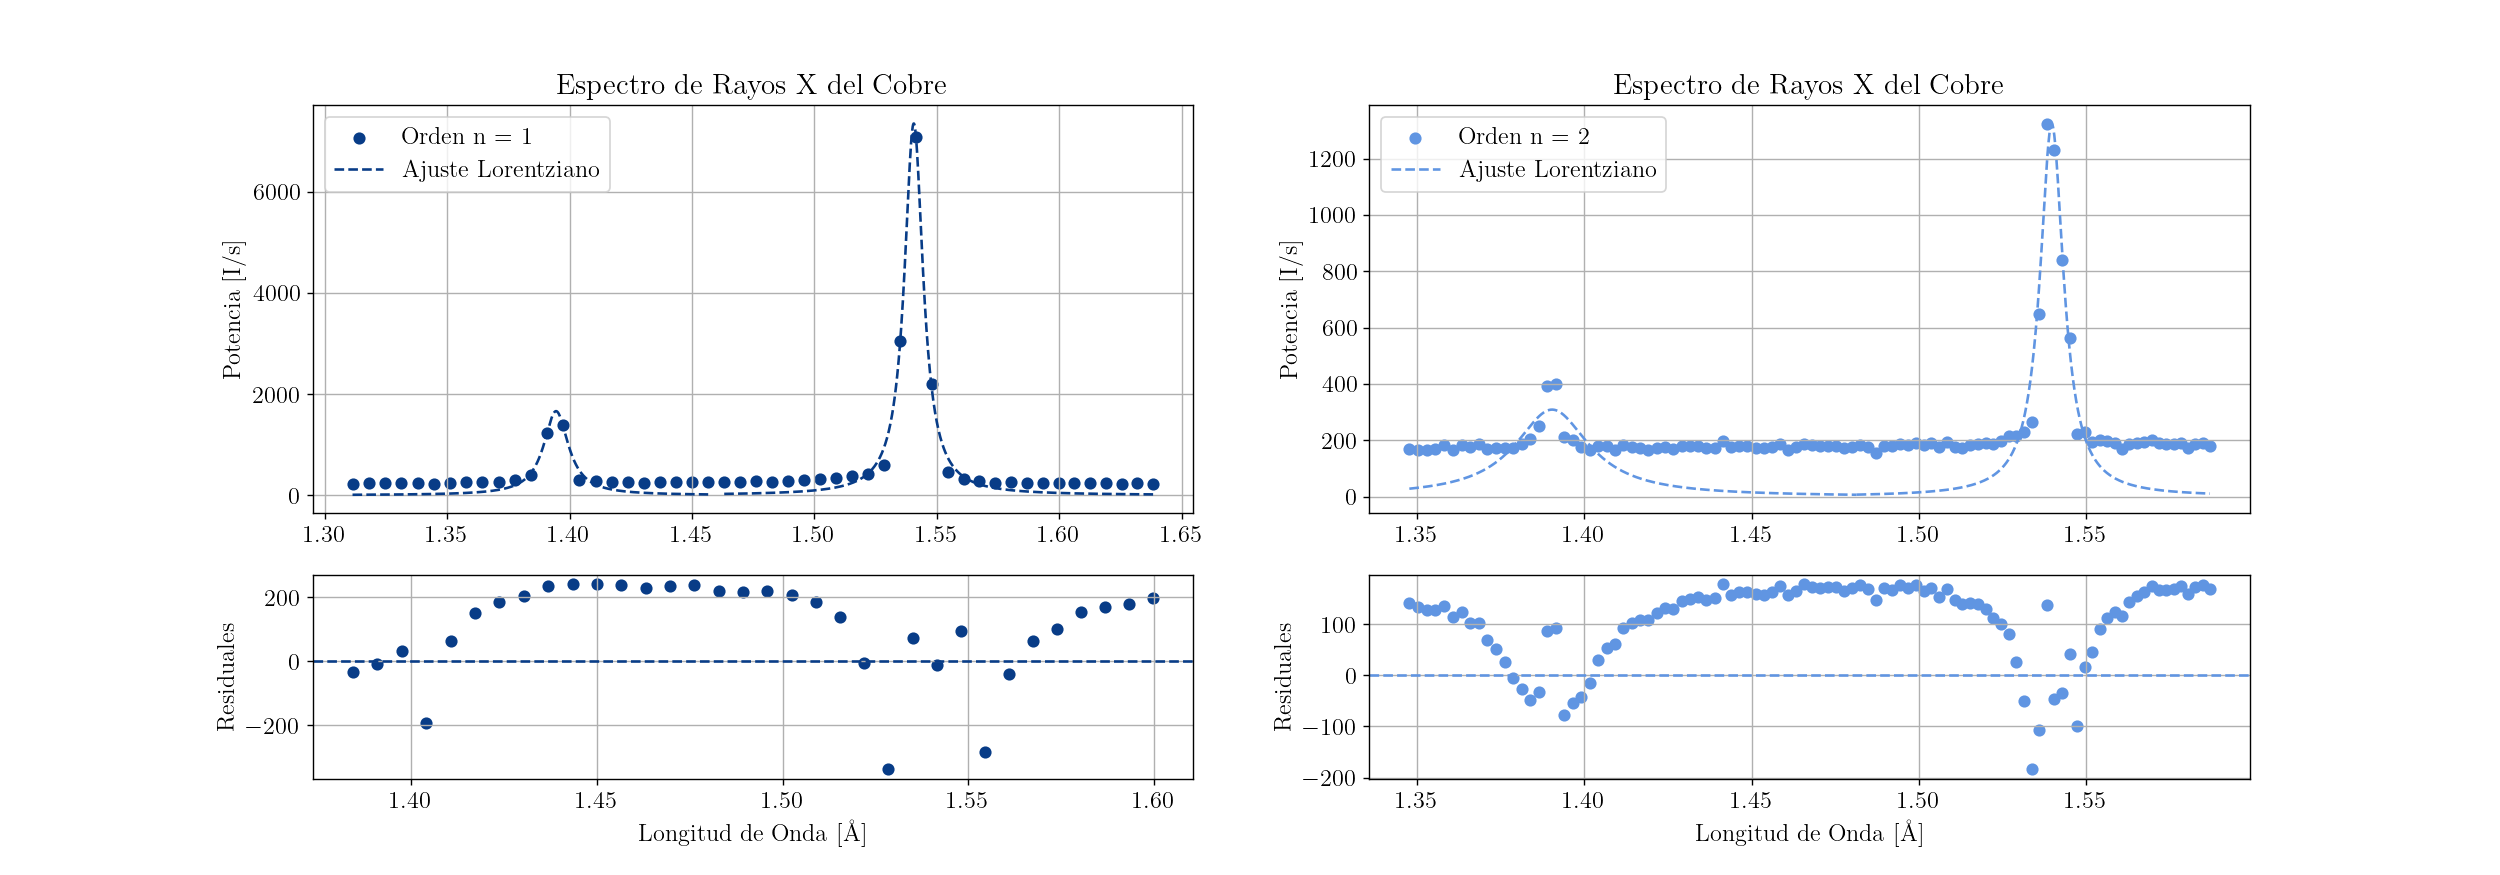

In [9]:
figure, axis = plt.subplots(2, 2, figsize = (20, 7), gridspec_kw={'height_ratios': [2, 1]})
axis[0, 0].scatter(x1, y1, color = "#083c87", label = "Orden n = 1")
axis[0, 0].plot(x1L1_, Lorentzian(x1L1_, *ILorenICu_var), color = "#083c87", linestyle = "--")
axis[0, 0].plot(x1L2_, Lorentzian(x1L2_, *ILorenIICu_var), color = "#083c87", linestyle = "--", label = "Ajuste Lorentziano")
axis[1, 0].set_xlabel("Longitud de Onda [Å]")
axis[0, 0].set_ylabel("Potencia [I/s]")
axis[0, 0].set_title("Espectro de Rayos X del Cobre")
axis[0, 0].legend()
axis[0, 0].grid()

axis[1, 0].scatter(x1L1, y1L1_Res, color = "#083c87")
axis[1, 0].scatter(x1L2, y1L2_Res, color = "#083c87")
axis[1, 0].set_ylabel("Residuales")
axis[1, 0].axhline(y = 0, color = "#083c87", linestyle = "--")
axis[1, 0].grid()


axis[0, 1].scatter(x2, y2, color = "#6095e2", label = "Orden n = 2")
axis[0, 1].plot(x2L1_, Lorentzian(x2L1_, *IILorenICu_var), color = "#6095e2", linestyle = "--")
axis[0, 1].plot(x2L2_, Lorentzian(x2L2_, *IILorenIICu_var), color = "#6095e2", linestyle = "--", label = "Ajuste Lorentziano")
axis[1, 1].set_xlabel("Longitud de Onda [Å]")
axis[0, 1].set_ylabel("Potencia [I/s]")
axis[0, 1].set_title("Espectro de Rayos X del Cobre")
axis[0, 1].legend()
axis[0, 1].grid()

axis[1, 1].scatter(x2[0:ward], y2L1_Res, color = "#6095e2")
axis[1, 1].scatter(x2[ward:], y2L2_Res, color = "#6095e2")
axis[1, 1].set_ylabel("Residuales")
axis[1, 1].axhline(y = 0, color = "#6095e2", linestyle = "--")
axis[1, 1].grid()

plt.show()

Se logra apreciar que el comportamiento que muestra este tipo de ajuste es más bien errático al modelar los puntos bajos tomados del espectro. Pese a esto, este método permite determinar cuál es el valor de los puntos máximos, que corresponden con las líneas espectrales, y así determinar su longitud de onda asociada:

In [10]:
ILorenKb = Error(ILorenICu_var[1], ILorenICu_unc[1])
ILorenKa = Error(ILorenIICu_var[1], ILorenIICu_unc[1])
IILorenKb = Error(IILorenICu_var[1], IILorenICu_unc[1])
IILorenKa = Error(IILorenIICu_var[1], IILorenIICu_unc[1])

display(Markdown(r'Lorentziana: La longitud de onda de $K_\alpha$ es {} $\pm$ {} y de $K_\beta$ es {} $\pm$ {} Å para el orden $n = 1$. Para el orden $n = 2$, la longitud de onda de  $K_\alpha$ es {} $\pm$ {} y de $K_\beta$ es {} $\pm$ {} Å.'.format(ILorenKa[0], ILorenKa[1], ILorenKb[0], ILorenKb[1], IILorenKa[0], IILorenKa[1], IILorenKb[0], IILorenKb[1])))

Lorentziana: La longitud de onda de $K_\alpha$ es 1.5406 $\pm$ 0.0003 y de $K_\beta$ es 1.3945 $\pm$ 0.0008 Å para el orden $n = 1$. Para el orden $n = 2$, la longitud de onda de  $K_\alpha$ es 1.5397 $\pm$ 0.0003 y de $K_\beta$ es 1.39 $\pm$ 0.001 Å.

Las líneas $K_{\alpha}$ y $K_{\beta}$ del cobre tienen longitudes de onda de $1.54$ Å y $1.39221$ Å, podemos apreciar que los resultados son muy cercanos a lo reportado a nivel teórico. Ahora bien, probemos un ajuste diferente, mediante el llamado Perfil de Voight:

In [11]:
# Perfiles de Voight para n = 1:

IVoightICu_var, IVoightICu_unc = curve_fit(Gauss, x1L1, y1L1)
IVoightIX = ILorenICu_var[1]
IVoightIW = ILorenICu_var[2]
IVoightIS = IVoightICu_var[3]

IVoightICu_var, IVoightICu_unc = curve_fit(Voigt, x1L1, y1L1, p0 = (4500, IVoightIX, IVoightIS, IVoightIW) )
IVoightIAmplitude, IVoightICenter, IVoightISigma, IVoightIGamma = IVoightICu_var
IVoightICu_unc = np.sqrt(np.diag(np.abs(IVoightICu_unc)))

IVoightIx1L1_ = np.linspace(min(x1), max(x1L1), 1000)

IVoightIICu_var, IVoightIICu_unc = curve_fit(Gauss, x1L2, y1L2)
IVoightIIX = ILorenIICu_var[1]
IVoightIIW = ILorenIICu_var[2]
IVoightIIS = IVoightIICu_var[3]

IVoightIICu_var, IVoightIICu_unc = curve_fit(Voigt, x1L2, y1L2, p0 = (4500, IVoightIIX, IVoightIIS, IVoightIIW) )
IVoightIIAmplitude, IVoightIICenter, IVoightIISigma, IVoightIIGamma = IVoightIICu_var
IVoightIICu_unc = np.diag(np.sqrt(np.abs(IVoightIICu_unc)))

IVoightIIx1L2_ = np.linspace(min(x1L2), max(x1), 1000)

IVoightIy1L1_Res = y1L1 -  Voigt(x1L1, *IVoightICu_var)
IVoightIy1L2_Res = y1L2 -  Voigt(x1L2, *IVoightIICu_var)

# Perfil de Voight para n = 2:
# Sólo se hace para la línea de Ka porque no hay información suficiente para la línea de Kb.

IIVoightIICu_var, IIVoightIICu_unc = curve_fit(Gauss, x2, y2)
IIVoightIIX = IILorenIICu_var[1]
IIVoightIIW = IILorenIICu_var[2]
IIVoightIIS = IIVoightIICu_var[3]

IIVoightIICu_var, IIVoightIICu_unc = curve_fit(Voigt, x2, y2, p0 = (4500, IIVoightIIX, IIVoightIIS, IIVoightIIW) )
IIVoightIIAmplitude, IIVoightIICenter, IIVoightIISigma, IIVoightIIGamma = IIVoightIICu_var
IIVoightIICu_unc = np.diag(np.sqrt(np.abs(IIVoightIICu_unc)))

IIVoightIIx2L2_ = np.linspace(min(x2), max(x2), 2000)
IIVoightIIy2L2_Res = y2 -  Voigt(x2, *IIVoightIICu_var)

<IPython.core.display.Javascript object>


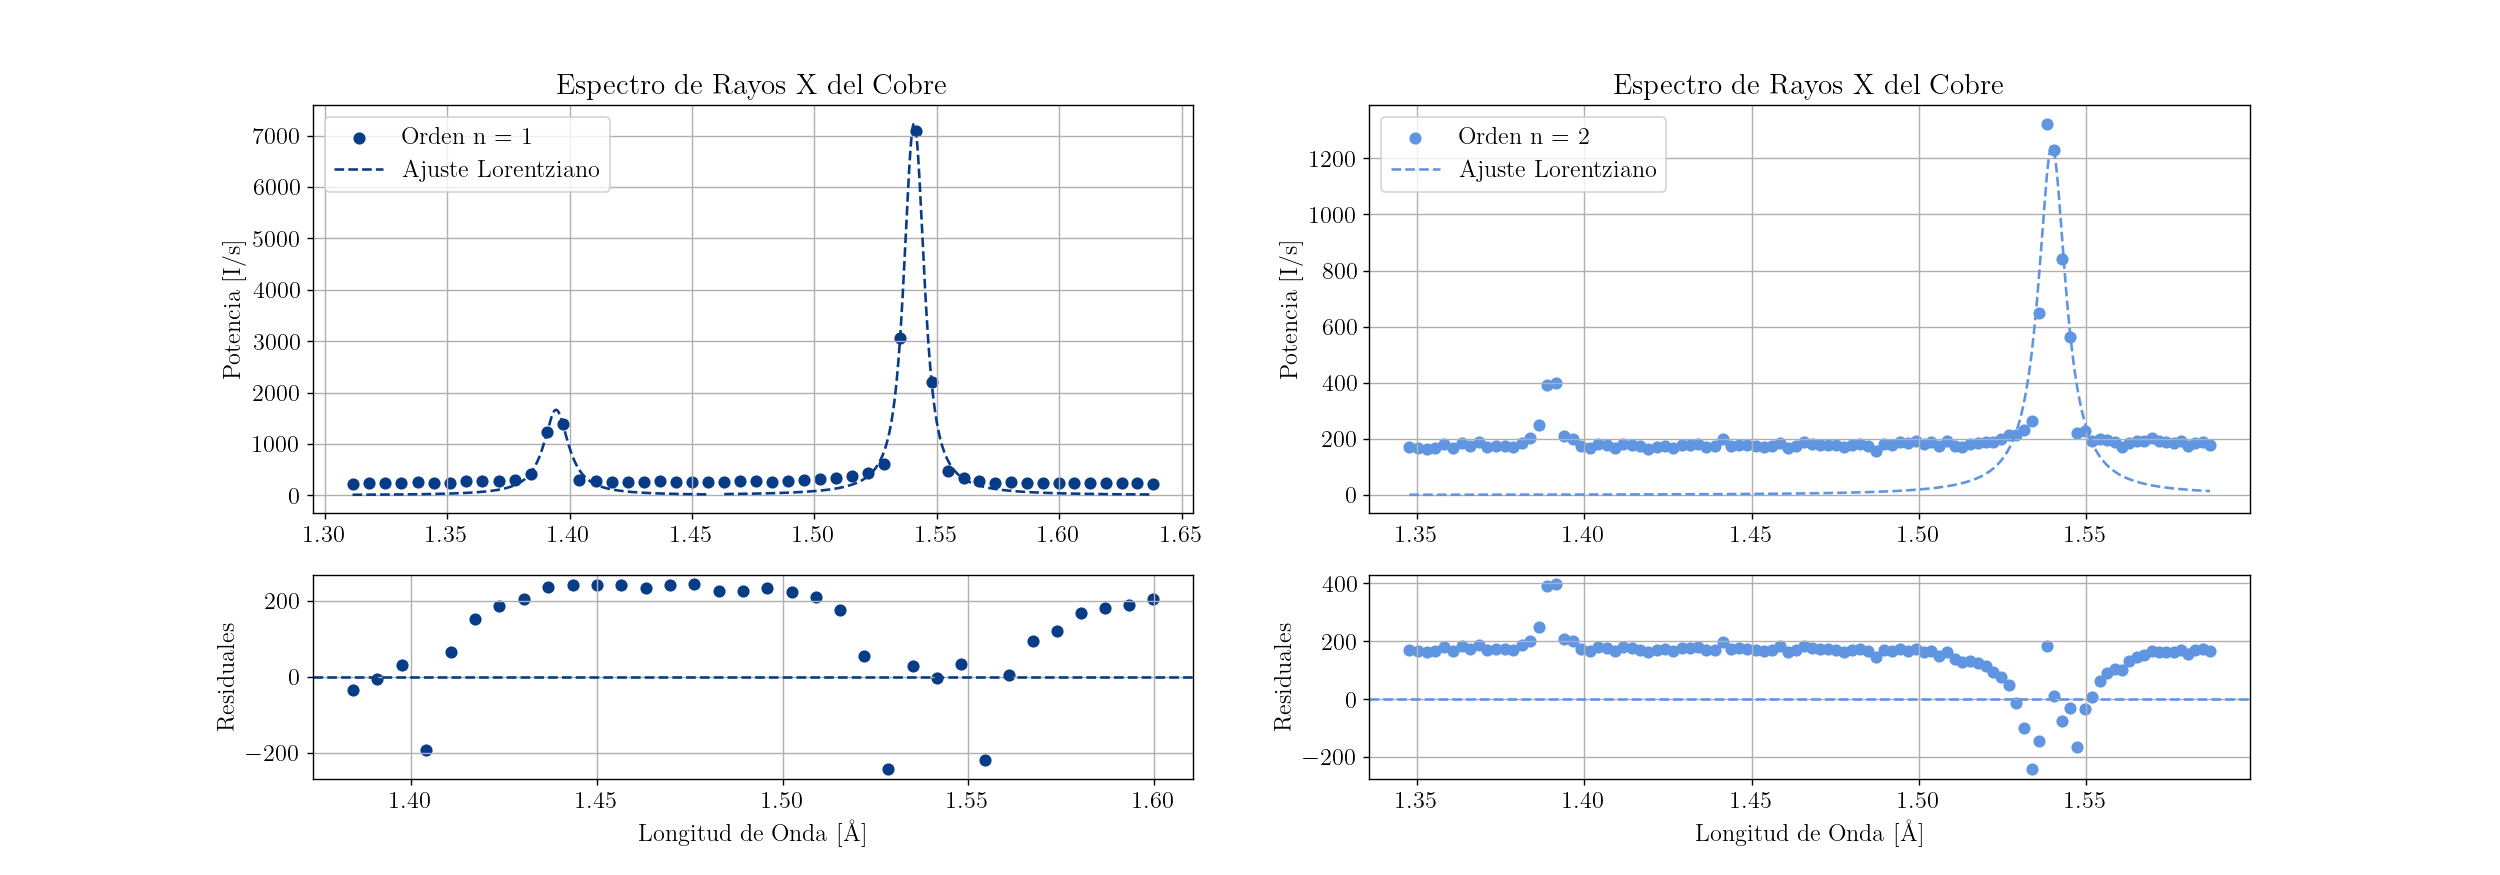

In [12]:
figure, axis = plt.subplots(2, 2, figsize = (20, 7), gridspec_kw={'height_ratios': [2, 1]})
axis[0, 0].scatter(x1, y1, color = "#083c87", label = "Orden n = 1")
axis[0, 0].plot(IVoightIx1L1_, Voigt(IVoightIx1L1_, *IVoightICu_var), color = "#083c87", linestyle = "--")
axis[0, 0].plot(IVoightIIx1L2_, Voigt(IVoightIIx1L2_, *IVoightIICu_var), color = "#083c87", linestyle = "--", label = "Ajuste Lorentziano")
axis[1, 0].set_xlabel("Longitud de Onda [Å]")
axis[0, 0].set_ylabel("Potencia [I/s]")
axis[0, 0].set_title("Espectro de Rayos X del Cobre")
axis[0, 0].legend()
axis[0, 0].grid()

axis[1, 0].scatter(x1L1, IVoightIy1L1_Res, color = "#083c87")
axis[1, 0].scatter(x1L2, IVoightIy1L2_Res, color = "#083c87")
axis[1, 0].set_ylabel("Residuales")
axis[1, 0].axhline(y = 0, color = "#083c87", linestyle = "--")
axis[1, 0].grid()


axis[0, 1].scatter(x2, y2, color = "#6095e2", label = "Orden n = 2")
axis[0, 1].plot(IIVoightIIx2L2_, Voigt(IIVoightIIx2L2_, *IIVoightIICu_var), color = "#6095e2", linestyle = "--", label = "Ajuste Lorentziano")
axis[1, 1].set_xlabel("Longitud de Onda [Å]")
axis[0, 1].set_ylabel("Potencia [I/s]")
axis[0, 1].set_title("Espectro de Rayos X del Cobre")
axis[0, 1].legend()
axis[0, 1].grid()


axis[1, 1].scatter(x2, IIVoightIIy2L2_Res, color = "#6095e2")
axis[1, 1].set_ylabel("Residuales")
axis[1, 1].axhline(y = 0, color = "#6095e2", linestyle = "--")
axis[1, 1].grid()

plt.show()

Ahora es posible apreciar, con el perfil de Voigt, resultados considerablementes más imprecisos con respecto al ajuste Lorentziano (Observar los Residuales). Con esto en mente, veamos el resultado de las líneas espectrales:

In [13]:
IVoightKb = Error(IVoightICenter, IVoightICu_unc[1])
IVoightKa = Error(IVoightIICenter, IVoightIICu_unc[1])
IIVoightKa = Error(IIVoightIICenter, IIVoightIICu_unc[1])

display(Markdown(r'Perfil de Voigt: La longitud de onda de $K_\alpha$ es {} $\pm$ {} y de $K_\beta$ es {} $\pm$ {} Å para el orden $n = 1$. Para el orden $n = 2$ sólo fue posible determinar la longitud de onda de  $K_\alpha$, siendo esta de {} $\pm$ {} Å.'.format(IVoightKa[0], IVoightKa[1], IVoightKb[0], IVoightKb[1], IIVoightKa[0], IIVoightKa[1])))

Perfil de Voigt: La longitud de onda de $K_\alpha$ es 1.5407 $\pm$ 0.0003 y de $K_\beta$ es 1.3945 $\pm$ 0.0009 Å para el orden $n = 1$. Para el orden $n = 2$ sólo fue posible determinar la longitud de onda de  $K_\alpha$, siendo esta de 1.5398 $\pm$ 0.0006 Å.

Estos resultados son muy similares a los que se consiguieron con el acercamiento con la Lorentziana. Ahora, partiendo de los resultados de esta primera aproximación, se obtuvieron los valores energéticos para estas cantidades:

In [14]:
h_, c_, wave, unc_h, unc_c, unc_wave = sym.symbols("h, c, lambda, sigma_h, sigma_c, sigma_lambda", real = True)

energy_exp = h_*c_/(wave*10e-10) * (1/(1.602176565e-19)) * (1e-3)
energy_sym = h_, c_, wave, unc_h, unc_c, unc_wave

waves = [(ILorenKa[0], ILorenKa[1]), (ILorenKb[0], ILorenKb[1]), (IILorenKa[0], IILorenKa[1]), (IILorenKb[0], IILorenKb[1])]
energies = []
for i in waves:
    energy_param = (h, c, i[0], 0, 0, i[1])

    energy, energy_error = Computation_Error(energy_exp, energy_sym, energy_param)
    energies.append((energy, energy_error))

In [15]:
display(Markdown(r'La energía asociada a la longitud de onda de $K_\alpha$ es de {} $\pm$ {} eV, la de la línea $K_\beta$ es de {} $\pm$ {} eV. Esto para el orden $n = 1$. Para el orden $n = 2$, la energía de la línea $K_\alpha$ es de {} $\pm$ {} eV, y la línea $K_\beta$ es de {} $\pm$ {} keV.'.format(energies[0][0], energies[0][1], energies[1][0], energies[1][1], energies[2][0], energies[2][1], energies[3][0], energies[3][1])))

La energía asociada a la longitud de onda de $K_\alpha$ es de 0.8048 $\pm$ 0.0002 eV, la de la línea $K_\beta$ es de 0.8891 $\pm$ 0.0005 eV. Esto para el orden $n = 1$. Para el orden $n = 2$, la energía de la línea $K_\alpha$ es de 0.8052 $\pm$ 0.0002 eV, y la línea $K_\beta$ es de 0.892 $\pm$ 0.0006 keV.

Los datos obtenidos se ven muy bien, en tanto corresponden con los valores teóricos y experimentales reportados en la literatura.

> **Actividad #2: Absorción de Rayos X.**

En esta actividad estudiaremos el comportamiento de absorción de los Rayos X para diferentes tipos de materiales y sus grosores. En este caso, el análisis de la absorción de los materiales será diferente para cada material debido a que las medidas se hicieron en sesiones diferentes.

---

> **Aluminio: Absorción de Rayos X.**

Para este material se analizará la aborsión en función de cinco valores de grosor diferente. Las medidas que realizamos se muestran a continuación:

In [16]:
Ambience = pd.read_csv(path + "Ambiente I.txt", sep = "	")
AmbI_Angle = Ambience["Angle"].to_numpy()
AmbI_Inten = Ambience["Intensity"].to_numpy()
AmbI_Angle = ChangeType(AmbI_Angle)
AmbI_Inten = ChangeType(AmbI_Inten)
AmbI_Wave = SetWave(AmbI_Angle, d, phase)

In [17]:
Al_thickness = ["Al 0.02mm.txt", "Al 0.04mm.txt", "Al 0.06mm.txt", "Al 0.08mm.txt", "Al 0.1mm.txt"]
Al_Colors = ["#154360", "#1a5276", "#1f618d", "#2471a3", "#2980b9"]

Al_Data = []
Al_Wave = []    

n = 5

for i in Al_thickness:
    Al = pd.read_csv(path + i, sep = "	")
    
    Alangle = Al["Angle"].to_numpy()
    AlInten = Al["Intensity"].to_numpy()
    Alangle = ChangeType(Alangle)
    AlInten = ChangeType(AlInten)
    
    Al_Data.append((Alangle, AlInten))
    
for i in range(0, n):
    Al_I = SetWave(Al_Data[i][0], d, phase)
    Al_Wave.append((Al_I, Al_Data[i][1]))

<IPython.core.display.Javascript object>


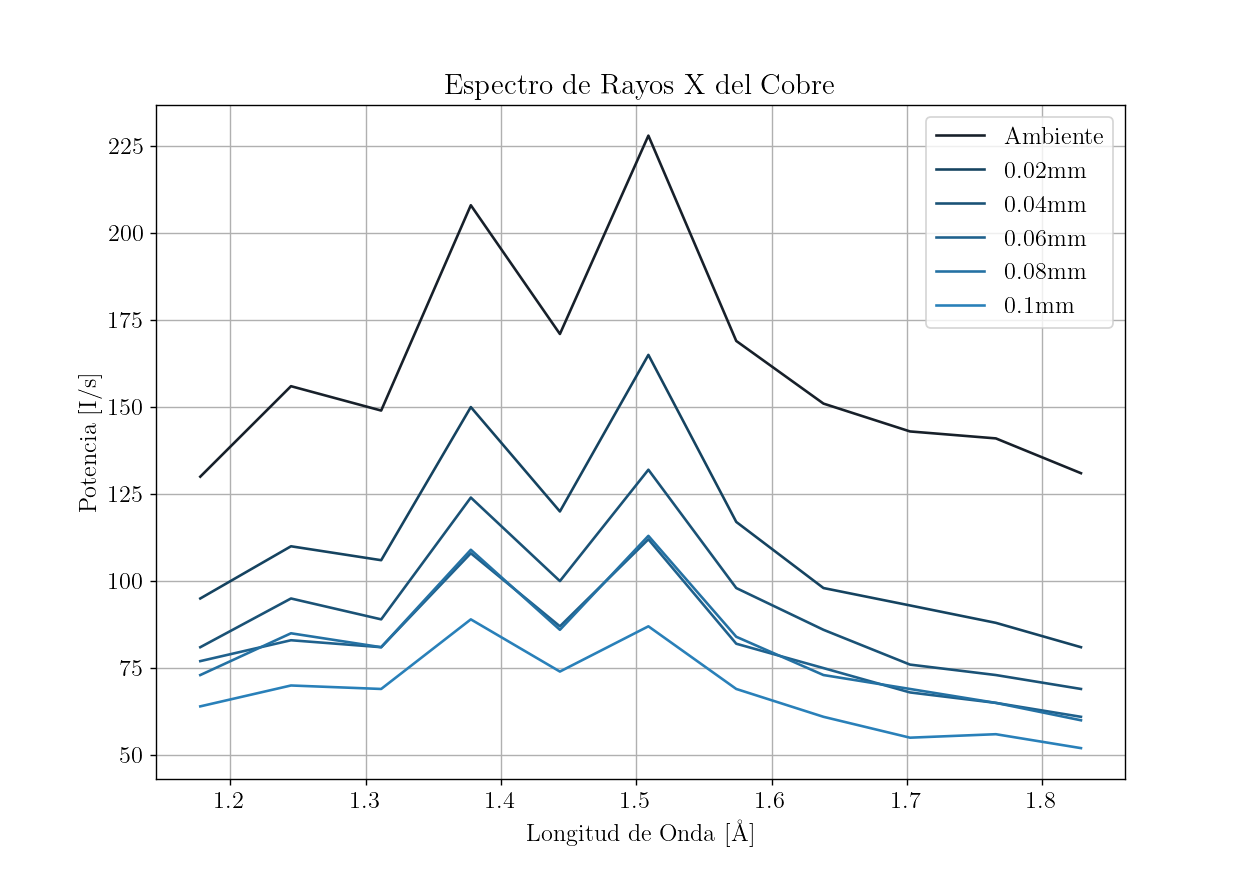

In [18]:
plt.figure(figsize = (10, 7))
plt.plot(AmbI_Wave, AmbI_Inten, color = "#17202a", label = "Ambiente")
plt.xlabel("Longitud de Onda [Å]")
plt.ylabel("Potencia [I/s]")
plt.title("Espectro de Rayos X del Cobre")
plt.grid()

for i in range(0, n):
    label_ = Al_thickness[i].replace("Al", "")
    label_ = label_.replace(".txt", "")
    plt.plot(Al_Wave[i][0], Al_Wave[i][1], color = Al_Colors[i], label = label_)
    
plt.legend()

Se logra apreciar que la diferencia entre la placa de Aluminio de grosor 0.06 mm y la de 0.08 mm no es del todo apreciable, seguramente tenga que ver con un error nuestro al no reemplazar la placa de Aluminio. Dependiendo del comportamiento en la tendencia que se mostrará a continuación, sabremos determinar cuál de los datos tomados es necesario de eliminar. Observemos lo que ocurre al realizar una regresión para determinar el coeficiente de absorción para cada **corte de longitud de onda**. Cada corte tendrá una regresión lineal asociada:

$$I = I_{0}e^{-\mu(\lambda, Z)d} \quad \Rightarrow \quad \ln\left(\frac{I}{I_{0}}\right) = -\mu(\lambda, Z)d$$

In [19]:
Abs_Wave = Al_Wave[0][0]
Abs_grossor = np.array([0.02, 0.04, 0.06, 0.08, 0.1])/1000
Absortion = [[], [], [], [], [], [], [], [], [], [], []]

for i in range(0, len(Al_Wave)):
    for j in range(0, len(Al_Wave[0][1])):
        Absortion[j].append(np.log(Al_Wave[i][1][j]/AmbI_Inten[j])) # Término logaritmico 

<IPython.core.display.Javascript object>


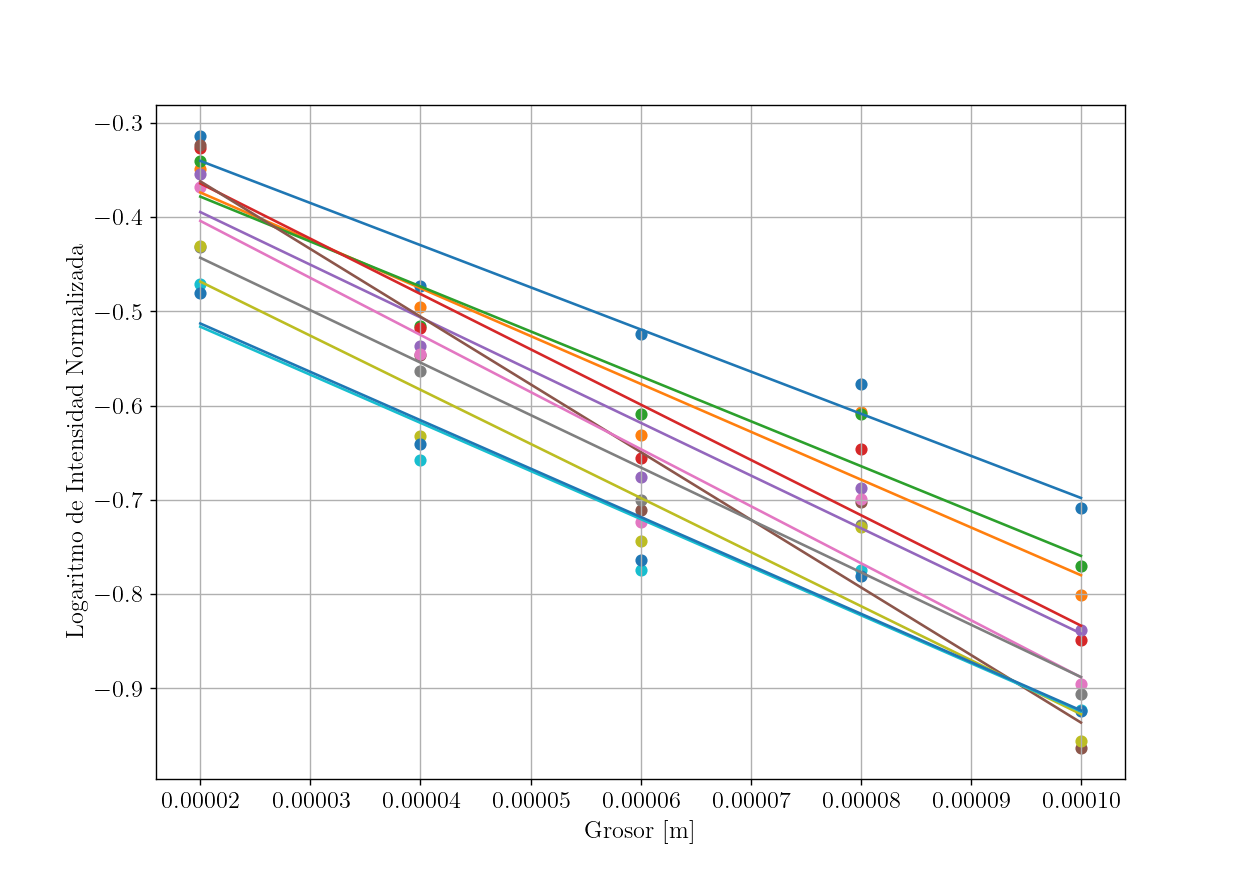

In [20]:
plt.figure(figsize = (10, 7))
Abs_Mu = []

for data in Absortion:
    AlLin_var, AlLin_unc = curve_fit(Linear, Abs_grossor, data)
    AlLin_unc = np.sqrt(np.diag(AlLin_unc))
    
    Abs_grossor_ = np.linspace(min(Abs_grossor), max(Abs_grossor), 100)
    plt.scatter(Abs_grossor, data)
    plt.plot(Abs_grossor_, Linear(Abs_grossor_, *AlLin_var))
    Abs_Mu.append((np.abs(AlLin_var[0]), AlLin_unc[0]))

Abs_Mu = np.array([Abs_Mu])
    
plt.xlabel("Grosor [m]")
plt.ylabel("Logaritmo de Intensidad Normalizada")
plt.grid()
plt.show()

Las gráficas anteriores son meramente ilustrativas del comportamiento del logaritmo de la intensidad normalizada en términos del grosor del material. Estas regresiones permiten calcular los coeficientes de absorción asociados al aluminio. Ahora, realizando la gráfica de:

$$\frac{\mu}{\rho} = k(\lambda Z)^{3}$$

---

Una cosa a notar es que los valores asociados a 0.08mm arruinan la tendencia lineal decreciente. Esto implica que lo más probable es que sea esta medición la que repetimos de manera inconsciente. Por tanto, removeremos este conjunto de datos del análisis posterior.

In [21]:
Al_thickness = ["Al 0.02mm.txt", "Al 0.04mm.txt", "Al 0.06mm.txt", "Al 0.1mm.txt"]
Al_Colors = ["#154360", "#1a5276", "#1f618d", "#2471a3"]

Al_Data = []
Al_Wave = []    

n = 4

for i in Al_thickness:
    Al = pd.read_csv(path + i, sep = "	")
    
    Alangle = Al["Angle"].to_numpy()
    AlInten = Al["Intensity"].to_numpy()
    Alangle = ChangeType(Alangle)
    AlInten = ChangeType(AlInten)
    
    Al_Data.append((Alangle, AlInten))
    
for i in range(0, n):
    Al_I = SetWave(Al_Data[i][0], d, phase)
    Al_Wave.append((Al_I, Al_Data[i][1]))

<IPython.core.display.Javascript object>


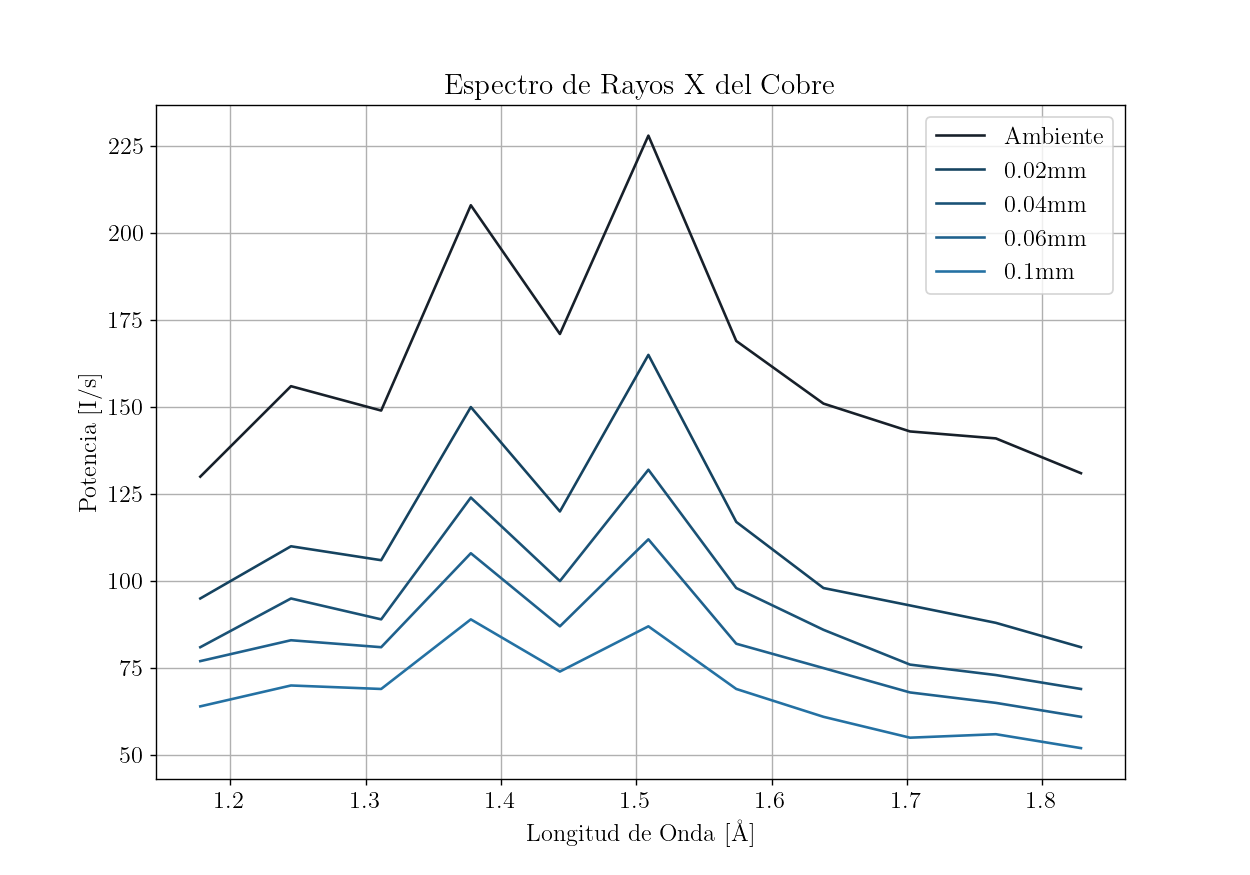

In [22]:
plt.figure(figsize = (10, 7))
plt.plot(AmbI_Wave, AmbI_Inten, color = "#17202a", label = "Ambiente")
plt.xlabel("Longitud de Onda [Å]")
plt.ylabel("Potencia [I/s]")
plt.title("Espectro de Rayos X del Cobre")
plt.grid()

for i in range(0, n):
    label_ = Al_thickness[i].replace("Al", "")
    label_ = label_.replace(".txt", "")
    plt.plot(Al_Wave[i][0], Al_Wave[i][1], color = Al_Colors[i], label = label_)
    
plt.legend()

In [23]:
Abs_Wave = Al_Wave[0][0]
Abs_grossor = np.array([0.02, 0.04, 0.06, 0.1])/1000
Absortion = [[], [], [], [], [], [], [], [], [], [], []]

for i in range(0, len(Al_Wave)):
    for j in range(0, len(Al_Wave[0][1])):
        Absortion[j].append(np.log(Al_Wave[i][1][j]/AmbI_Inten[j])) # Término logaritmico 

<IPython.core.display.Javascript object>


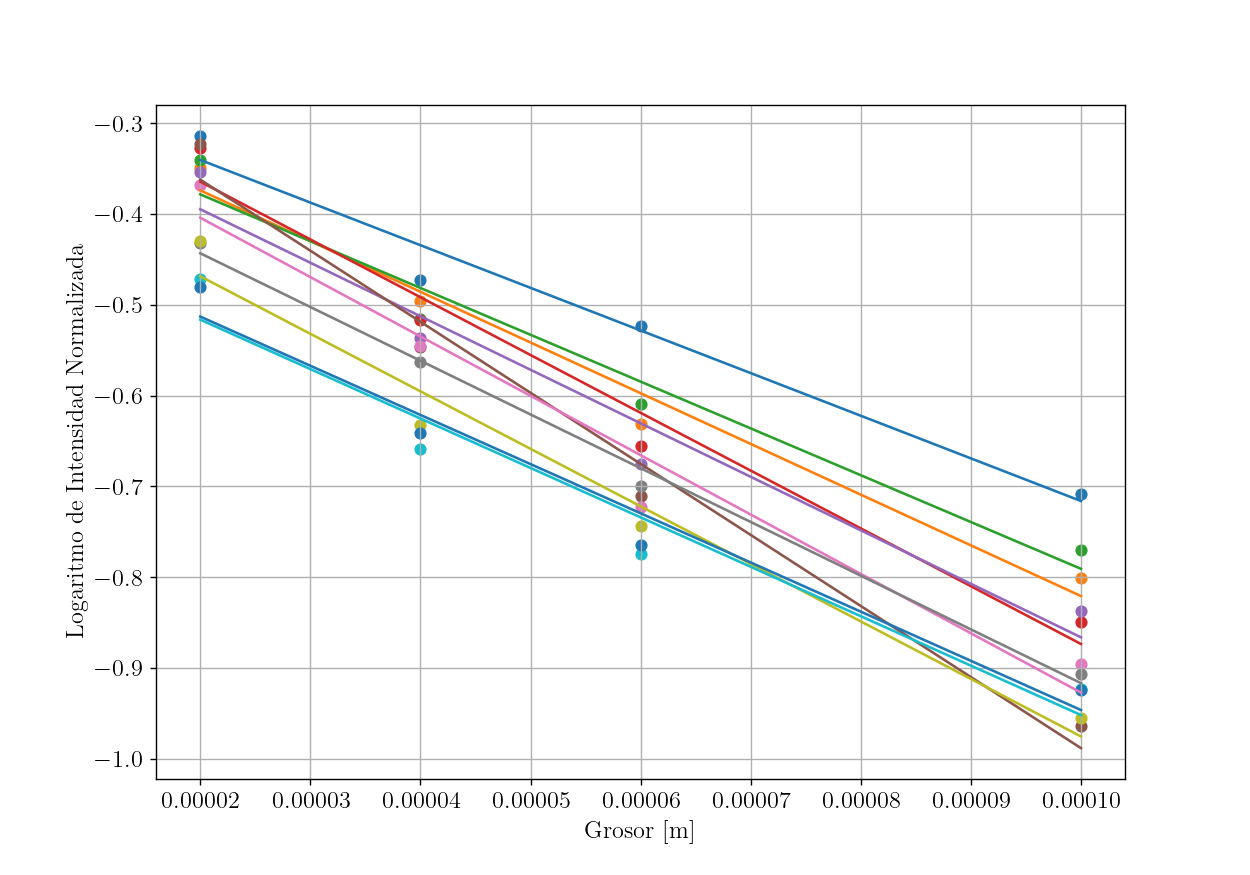

In [24]:
plt.figure(figsize = (10, 7))
Abs_Mu_all = []

for data in Absortion:
    AlLin_var, AlLin_unc = curve_fit(Linear, Abs_grossor, data)
    AlLin_unc = np.sqrt(np.diag(AlLin_unc))
    
    Abs_grossor_ = np.linspace(min(Abs_grossor), max(Abs_grossor), 100)
    plt.scatter(Abs_grossor, data)
    plt.plot(Abs_grossor_, Linear(Abs_grossor_, *AlLin_var))
    
    Abs_Mu_all.append((np.abs(AlLin_var[0]), AlLin_unc[0]))

Abs_Mu_all = np.array([Abs_Mu_all])
    
plt.xlabel("Grosor [m]")
plt.ylabel("Logaritmo de Intensidad Normalizada")
plt.grid()
plt.show()

Ahora sí, construyendo la nueva regresión se obtiene:

In [25]:
rho_Al = 2698.4 #kg/m^(3)
AlZ = 13

In [26]:
Abs_Mu = []
Abs_Mu_unc = []

for i in range(len(Abs_Mu_all[0])):  
    Abs_Mu.append(Abs_Mu_all[0][i][0])
    Abs_Mu_unc.append(Abs_Mu_all[0][i][1])

Abs_Mu = np.array(Abs_Mu)
Abs_Mu_unc = np.array(Abs_Mu_unc)
    
Abs_Rhu = Abs_Mu/rho_Al

<IPython.core.display.Javascript object>


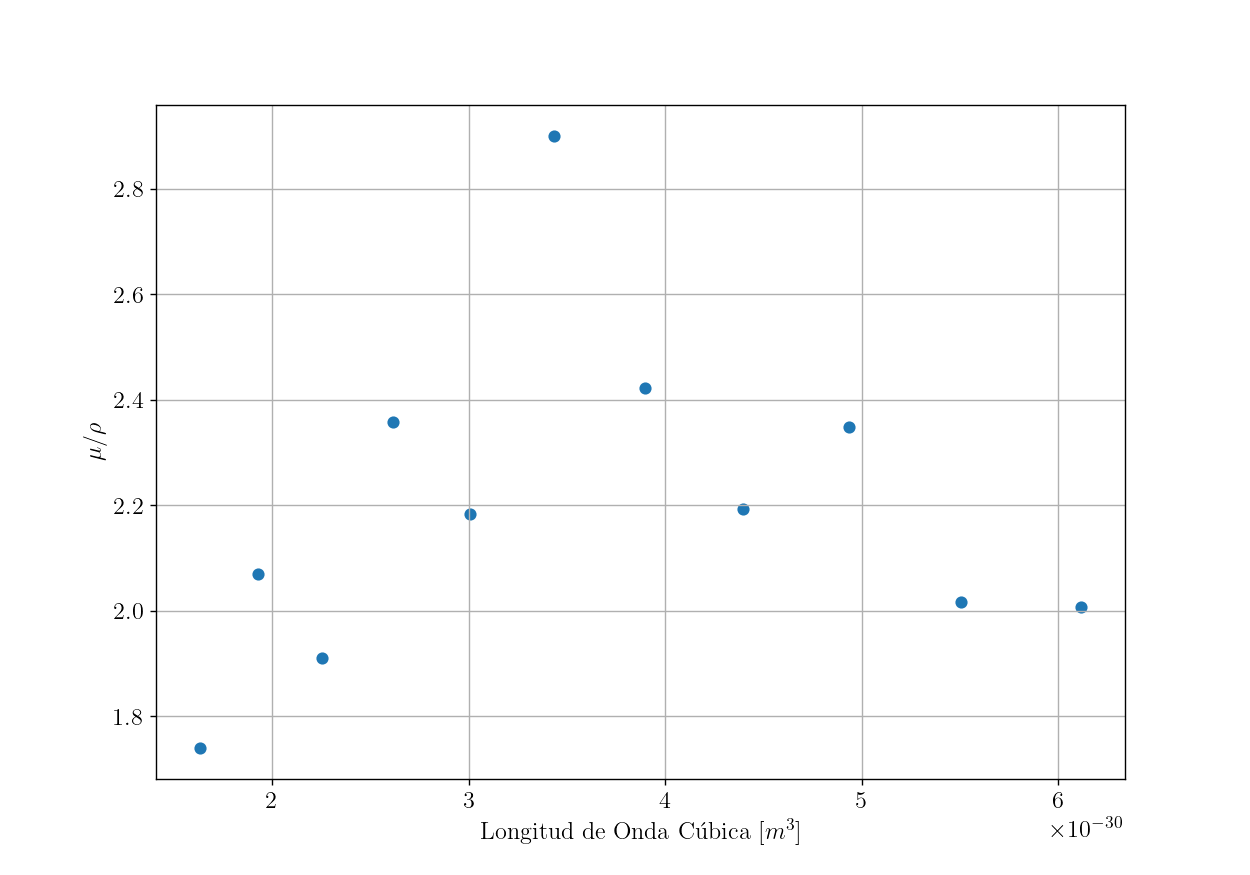

In [27]:
plt.figure(figsize = (10, 7))
plt.scatter((Abs_Wave*1e-10)**3, Abs_Rhu)

plt.xlabel(r"Longitud de Onda Cúbica $[m^3]$")
plt.ylabel(r"$\mu/\rho$")
plt.grid()
plt.show()

En este caso en particular no entendemos el por qué no se observa ningún comportamiento claro del coeficiente de absorción. Se dejará para analizar con mucho más tiempo y espacio en el informe.

---

> **Segunda Sesión: Octubre 17 - 2024.**

**Calibración:** Para esta segunda y última sesión se debe de considerar la siguiente configuración asociada a la intensidad máxima medida y los ángulos asociados a cada uno de los componentes:

**Intensidad Máxima:** $7300$ $I/s$

**Ángulo del Cristal:** $20.6^{\circ}$

**Ángulo del Detector:** $40.1^{\circ}$

En esta sesión se logró completar la Actividad #2 y terminar la Actividad #3. No fue posible recopilar datos adecuados para mostrar la Ley de Duane-Hunt.

---

> **Zinc: Absorción de Rayos X.**

Para este material se analizará la aborsión en función de cuatro valores de grosor diferente. Las medidas que realizamos se muestran a continuación:

In [28]:
Ambience = pd.read_csv(path + "Ambiente II.txt", sep = "	")
AmbII_Angle = Ambience["Angle"].to_numpy()
AmbII_Inten = Ambience["Intensity"].to_numpy()
AmbII_Angle = ChangeType(AmbII_Angle)
AmbII_Inten = ChangeType(AmbII_Inten)
AmbII_Wave = SetWave(AmbII_Angle, d, phase)

In [29]:
Zn_thickness = ["Zn 0.025mm.txt", "Zn 0.05mm.txt", "Zn 0.075mm.txt", "Zn 0.1mm.txt", "Al 0.1mm.txt"]
Zn_Colors = ["#154360", "#1a5276", "#1f618d", "#2471a3", "#2980b9"]

Zn_Data = []
Zn_Wave = []    

n = 4

for i in Al_thickness:
    Zn = pd.read_csv(path + i, sep = "	")
    
    Znangle = Zn["Angle"].to_numpy()
    ZnInten = Zn["Intensity"].to_numpy()
    Znangle = ChangeType(Znangle)
    ZnInten = ChangeType(ZnInten)
    
    Zn_Data.append((Znangle, ZnInten))
    
for i in range(0, n):
    Zn_I = SetWave(Zn_Data[i][0], d, phase)
    Zn_Wave.append((Zn_I, Zn_Data[i][1]))

<IPython.core.display.Javascript object>


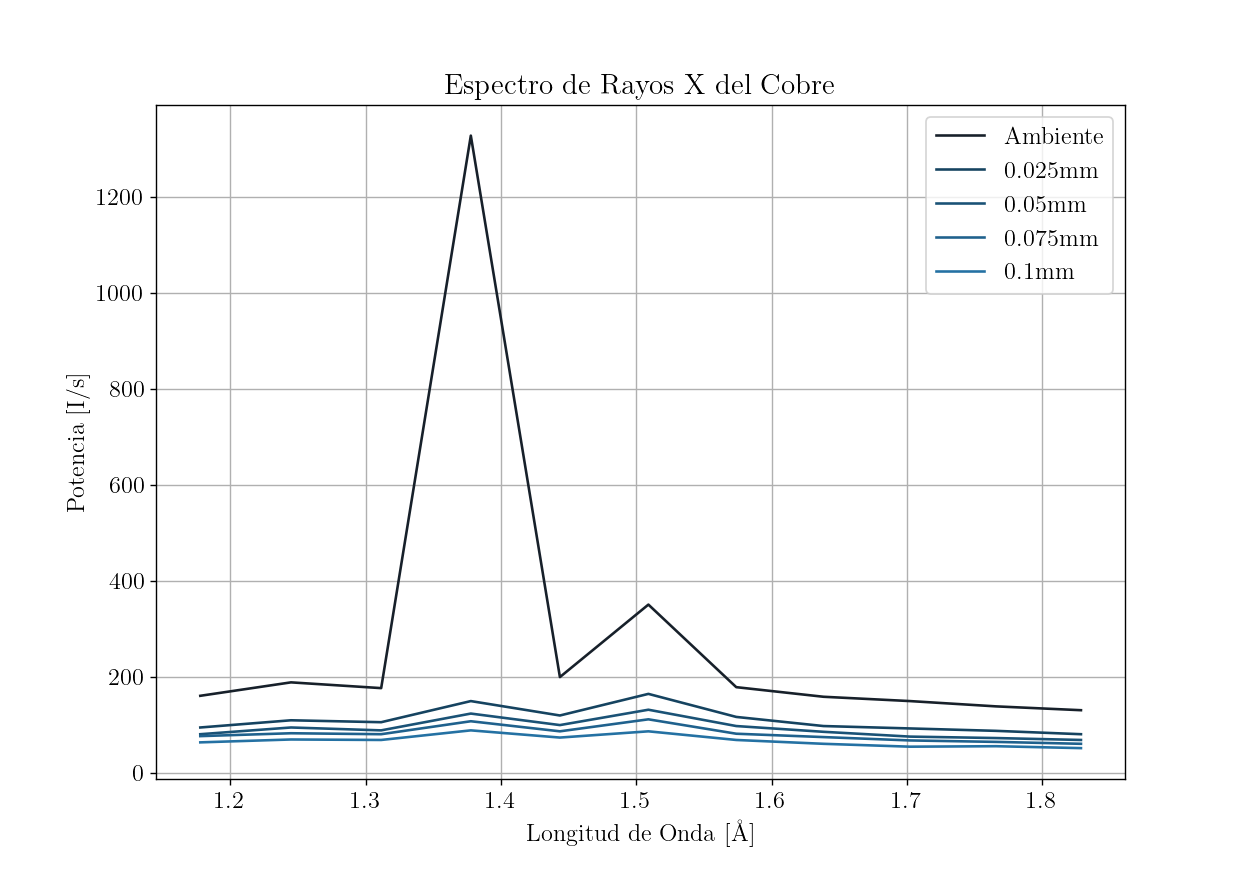

In [30]:
plt.figure(figsize = (10, 7))
plt.plot(AmbII_Wave, AmbII_Inten, color = "#17202a", label = "Ambiente")
plt.xlabel("Longitud de Onda [Å]")
plt.ylabel("Potencia [I/s]")
plt.title("Espectro de Rayos X del Cobre")
plt.grid()

for i in range(0, n):
    label_ = Zn_thickness[i].replace("Zn", "")
    label_ = label_.replace(".txt", "")
    plt.plot(Zn_Wave[i][0], Zn_Wave[i][1], color = Zn_Colors[i], label = label_)
    
plt.legend()

In [31]:
Abs_Wave = Zn_Wave[0][0]
Abs_grossor = np.array([0.025, 0.05, 0.075, 0.1])/1000
Absortion = [[], [], [], [], [], [], [], [], [], [], []]

for i in range(0, len(Zn_Wave)):
    for j in range(0, len(Zn_Wave[0][1])):
        Absortion[j].append(np.log(Zn_Wave[i][1][j]/AmbII_Inten[j])) # Término logaritmico 

<IPython.core.display.Javascript object>


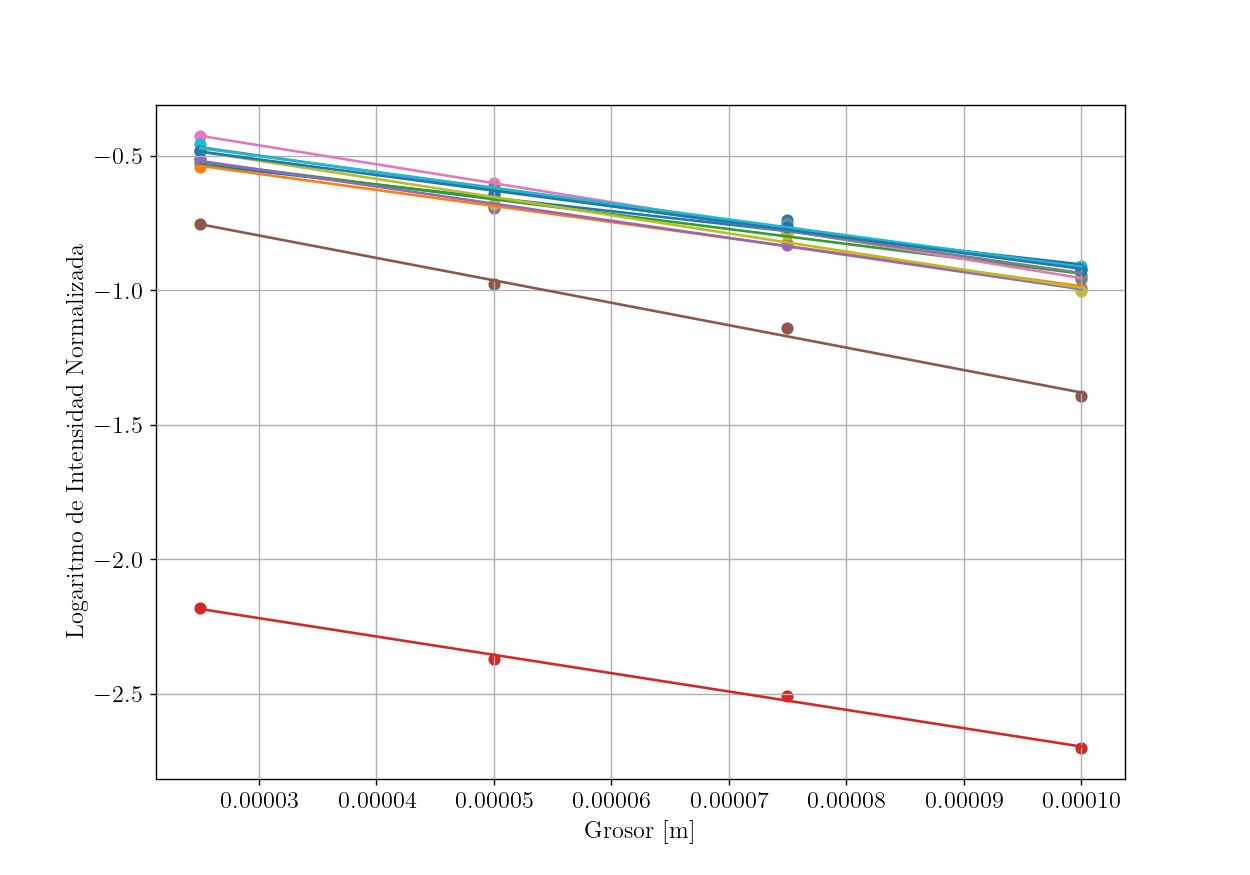

In [32]:
plt.figure(figsize = (10, 7))
Abs_Mu_all = []

for data in Absortion:
    ZnLin_var, ZnLin_unc = curve_fit(Linear, Abs_grossor, data)
    ZnLin_unc = np.sqrt(np.diag(ZnLin_unc))
    
    Abs_grossor_ = np.linspace(min(Abs_grossor), max(Abs_grossor), 100)
    plt.scatter(Abs_grossor, data)
    plt.plot(Abs_grossor_, Linear(Abs_grossor_, *ZnLin_var))
    
    Abs_Mu_all.append((np.abs(ZnLin_var[0]), ZnLin_unc[0]))

Abs_Mu_all = np.array([Abs_Mu_all])
    
plt.xlabel("Grosor [m]")
plt.ylabel("Logaritmo de Intensidad Normalizada")
plt.grid()
plt.show()

In [33]:
rho_Zn = 7138 #kg/m^(3)
ZnZ = 30

In [34]:
Abs_Mu = []
Abs_Mu_unc = []

for i in range(len(Abs_Mu_all[0])):  
    Abs_Mu.append(Abs_Mu_all[0][i][0])
    Abs_Mu_unc.append(Abs_Mu_all[0][i][1])

Abs_Mu = np.array(Abs_Mu)
Abs_Mu_unc = np.array(Abs_Mu_unc)
    
Abs_Rhu = Abs_Mu/rho_Zn

<IPython.core.display.Javascript object>


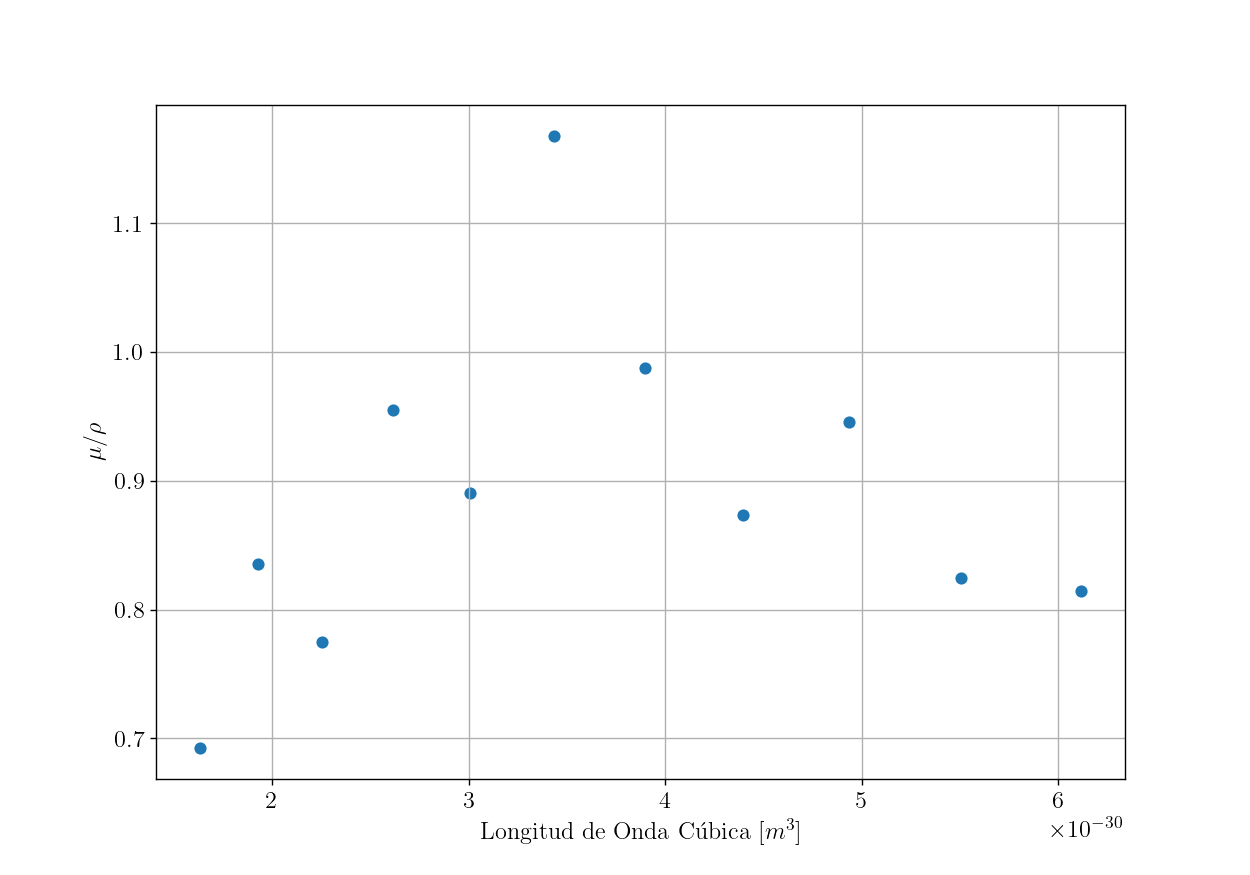

In [35]:
plt.figure(figsize = (10, 7))
plt.scatter((Abs_Wave*1e-10)**3, Abs_Rhu)

plt.xlabel(r"Longitud de Onda Cúbica $[m^3]$")
plt.ylabel(r"$\mu/\rho$")
plt.grid()
plt.show()

En este caso se logra observar un comportamiento realmente similar al que ocurre con el aluminio, sólo que con menor magnitud. Posiblemente sea un error sistemático al momento de realizar los cálculos, así que se tendrá en cuenta para un análisis posterior. Esto es un análisis netamente preliminar.

---

> **Actividad #3: Dependencia de la Intensidad del Voltaje y Corriente del Ánodo.**

En esta actividad estudiaremos el comportamiento de la intensidad de los Rayos X para diferentes valores de voltaje, a corriente constante, y para diferentes valores de corriente, para voltaje constante. Se realizarán regresiones que satisfagan la forma:

$$I = bI_{A}(U_{A} - U_{K})^{3/2}$$

Considerando $U_{K} = 9.979$ keV, el potencial de ionización del orbital K.


In [36]:
Uk = 9.979 # kV (?)
Ua = 35 # kV
I0 = 1 # 1mA

def KPotential(I, b):
    return b*I*(Ua - Uk)**(3/2)

def KCurrent(U, b):
    return b*I0*(U - Uk)**(3/2)

Para una corriente constante de 1mA se tiene:

In [57]:
KCurrent = pd.read_csv(path + "KCurrent.txt", sep = "	")
Indexes = ["11kV", "13kV", "15kV", "17kV", "19kV", "21kV", "23kV", "25kV", "27kV", "29kV", "31kV", "33kV", "35kV"]
Intensities = []

for i in range(0, len(Indexes)):
    Intensities.append(ChangeType(KCurrent[Indexes[i]].to_numpy()))

Angles = ChangeType(KCurrent["Angle"].to_numpy())
Waves = SetWave(Angles, d, phase)

<IPython.core.display.Javascript object>


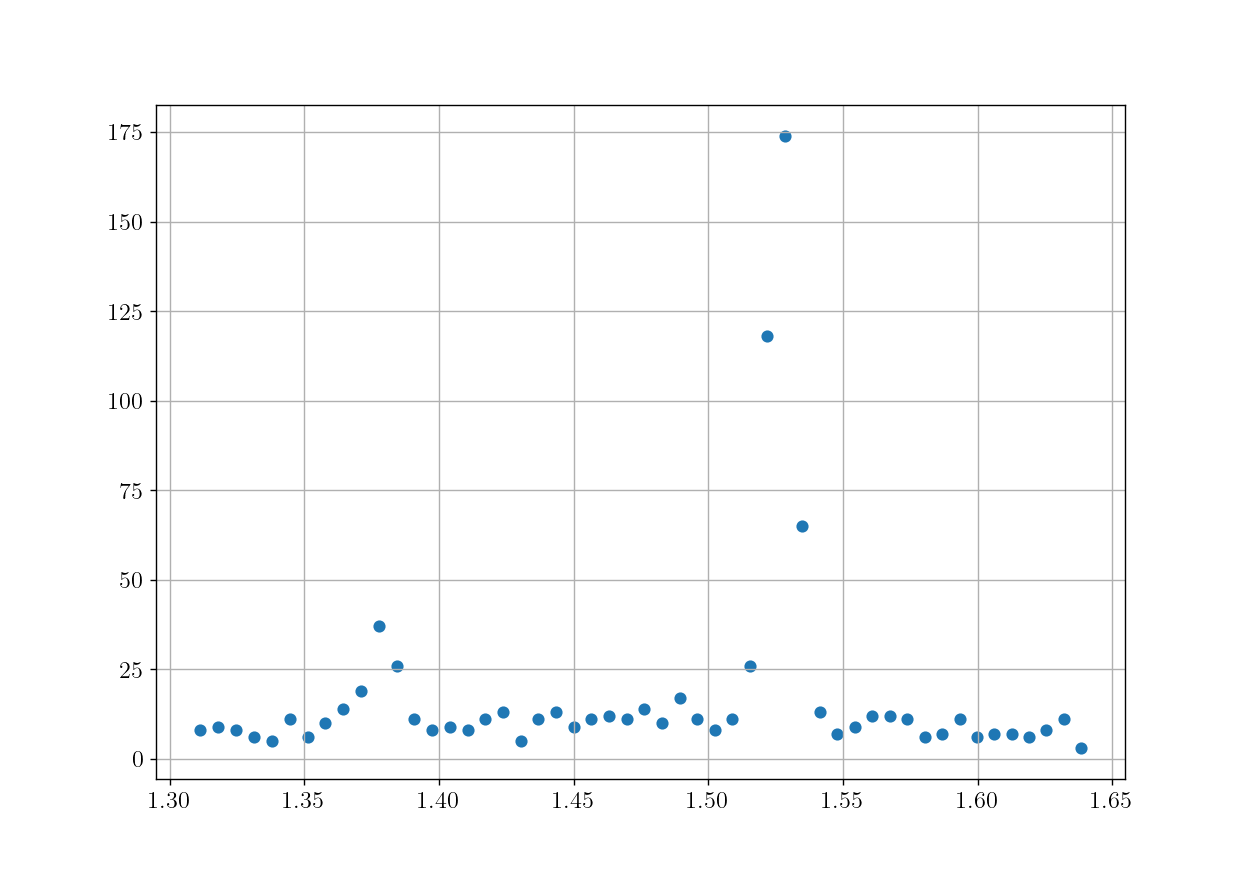

In [63]:
plt.figure(figsize = (10, 7))
plt.scatter(Waves, Intensities[0])
plt.show()
plt.grid()

El análisis del resto de datos se hará posteriormente. Perdón :(